In [42]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib as mpl
from statsmodels.tsa.forecasting.theta import ThetaModel

In [43]:
df = pd.read_csv("nike-q-revenue.csv")

In [55]:
df.head(5)

,Date,Quarterly Revenue
0,2009-03-31,3430000000
1,2009-06-30,3346000000
2,2009-09-30,4127000000
3,2009-12-31,3523000000
4,2010-03-31,3534000000


In [56]:
df.dtypes

Date                 object
Quarterly Revenue     int64
dtype: object

In [57]:
df.shape

(58, 2)

In [58]:
df.isnull().sum()

Date                 0
Quarterly Revenue    0
dtype: int64

In [59]:
class CustomFormatter(ticker.Formatter):
    def __call__(self, x, pos=None):
        if x >= 1e9:
            value = x / 1e9
            unit = 'Bln'
        elif x< 1e9 and x>= 1e6:
            value = x / 1e6
            unit = 'Mln'
        else:
            value = x
            unit = ''
        return f"{value:.1f} {unit}"

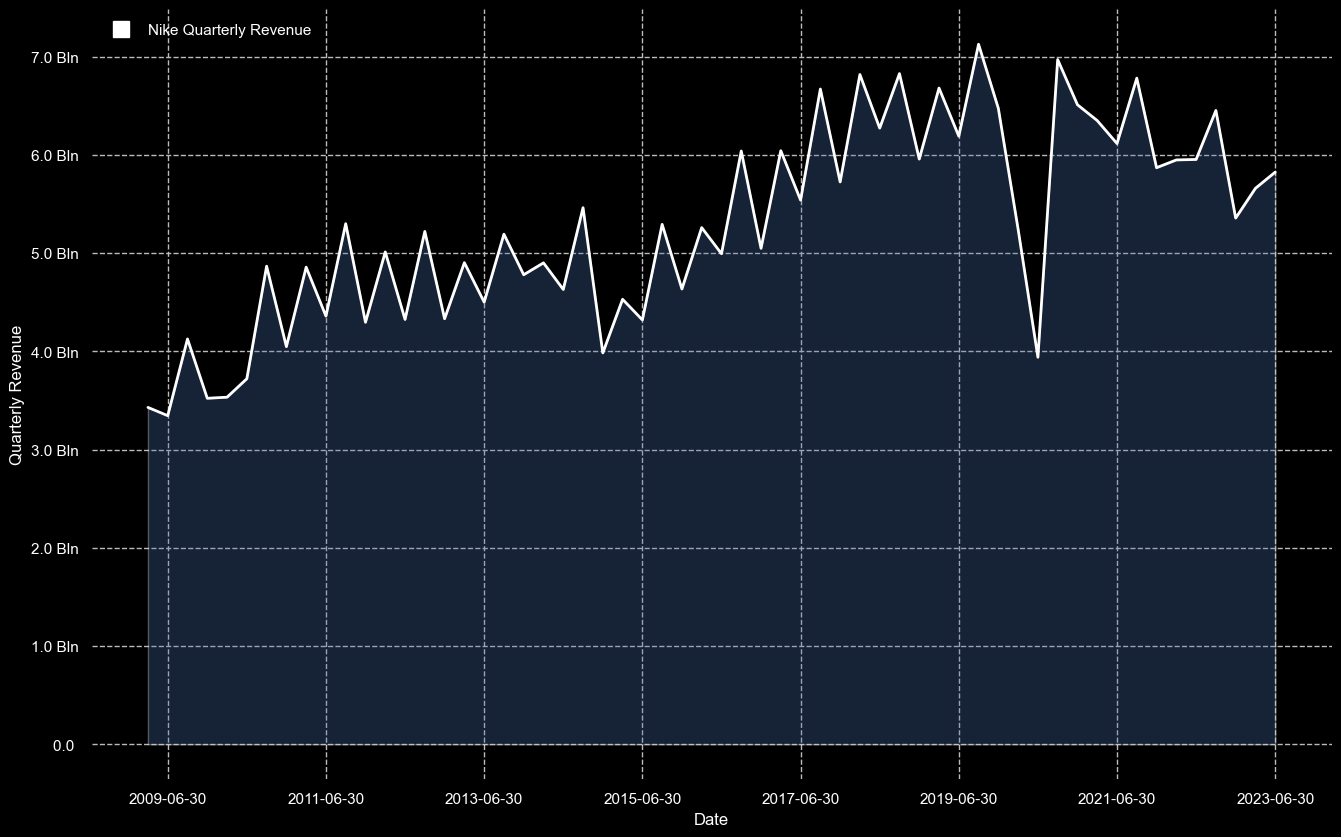

In [60]:
sns.set_theme(color_codes=True)
sns.set(rc={'figure.figsize':(16,10)})
sns.set(rc={'axes.facecolor':'#000', 'figure.facecolor':'#000'})
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(linestyle='--', color="#bdbaba")
ax = sns.lineplot(data=df, x="Date", y="Quarterly Revenue", linewidth = 2, color="white")
ax.set(ylabel='Quarterly Revenue', xlabel="Date")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_xticks(range(1, 60,8))
plt.xticks(rotation=0)
plt.fill_between(df['Date'], df['Quarterly Revenue'], alpha=0.3)
# Define custom legend handler with a square marker
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Nike Quarterly Revenue', 
                          linestyle='None', markerfacecolor='white', markersize=12)]
ax.legend(handles=legend_elements, labelcolor='white', loc='upper left', bbox_to_anchor=(0, 1), frameon=False)
sns.despine(left=True, bottom=True)
# Set the y-axis formatter
ax = plt.gca()
formatter = CustomFormatter()
ax.yaxis.set_major_formatter(formatter)

In [61]:
# Convert the Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort the data by date
df.sort_index(inplace=True)

# Convert the index to a PeriodIndex with quarterly frequency
df.index = df.index.to_period(freq='Q')

In [62]:
# Fit the ThetaModel
mod = ThetaModel(df['Quarterly Revenue'])
res = mod.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:      Quarterly Revenue   No. Observations:                   58
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Mon, 23 Oct 2023   Deseas. Method:         Multiplicative
Time:                        16:29:19   Period:                              4
Sample:                    03-31-2009                                         
                         - 06-30-2023                                         
  Parameter Estimates   
          Parameters    
------------------------
b0    46595464.046368666
alpha 0.6092047183140206
------------------------


In [63]:
# Predict the next 4-8 quarters with different theta lines
forecasts = pd.DataFrame(
    {
        "Quarterly Revenue": df['Quarterly Revenue'],
        "theta=1.2": res.forecast(steps=8, theta=1.2),
        "theta=2": res.forecast(steps=8),
        "theta=3": res.forecast(steps=8, theta=3),
        "No damping": res.forecast(steps=8, theta=np.inf),
    },
    index=pd.period_range(start=df.index[-1], periods=9, freq='Q')[1:]  # Index for forecasted values
)

In [64]:
forecasts

,Quarterly Revenue,theta=1.2,theta=2,theta=3,No damping
2023Q3,NaN,6.756618e+09,6.785082e+09,6.799314e+09,6.827778e+09
2023Q4,NaN,5.721698e+09,5.760436e+09,5.779806e+09,5.818545e+09
2024Q1,NaN,6.131465e+09,6.188620e+09,6.217198e+09,6.274354e+09
2024Q2,NaN,5.642521e+09,5.709477e+09,5.742955e+09,5.809911e+09
2024Q3,NaN,6.791299e+09,6.889125e+09,6.938038e+09,7.035863e+09
2024Q4,NaN,5.751029e+09,5.848430e+09,5.897130e+09,5.994531e+09
2025Q1,NaN,6.162856e+09,6.282795e+09,6.342764e+09,6.462702e+09
2025Q2,NaN,5.671372e+09,5.796031e+09,5.858360e+09,5.983019e+09


In [65]:
# Combine forecasts and df
combined_df = pd.concat([df, forecasts])

In [67]:
combined_df.tail(5)

,Quarterly Revenue,theta=1.2,theta=2,theta=3,No damping
2024Q2,NaN,5.642521e+09,5.709477e+09,5.742955e+09,5.809911e+09
2024Q3,NaN,6.791299e+09,6.889125e+09,6.938038e+09,7.035863e+09
2024Q4,NaN,5.751029e+09,5.848430e+09,5.897130e+09,5.994531e+09
2025Q1,NaN,6.162856e+09,6.282795e+09,6.342764e+09,6.462702e+09
2025Q2,NaN,5.671372e+09,5.796031e+09,5.858360e+09,5.983019e+09


In [68]:
combined_df.head(5)

,Quarterly Revenue,theta=1.2,theta=2,theta=3,No damping
2009Q1,3.430000e+09,NaN,NaN,NaN,NaN
2009Q2,3.346000e+09,NaN,NaN,NaN,NaN
2009Q3,4.127000e+09,NaN,NaN,NaN,NaN
2009Q4,3.523000e+09,NaN,NaN,NaN,NaN
2010Q1,3.534000e+09,NaN,NaN,NaN,NaN


In [76]:
# Reset index
combined_df = combined_df.reset_index()

# Rename index column to 'Date'
combined_df.rename(columns={'index': 'Date'}, inplace=True)

In [77]:
combined_df.head(5)

,Date,Quarterly Revenue,theta=1.2,theta=2,theta=3,No damping
0,2009Q1,3.430000e+09,NaN,NaN,NaN,NaN
1,2009Q2,3.346000e+09,NaN,NaN,NaN,NaN
2,2009Q3,4.127000e+09,NaN,NaN,NaN,NaN
3,2009Q4,3.523000e+09,NaN,NaN,NaN,NaN
4,2010Q1,3.534000e+09,NaN,NaN,NaN,NaN


In [80]:
combined_df.dtypes

Date                 period[Q-DEC]
Quarterly Revenue          float64
theta=1.2                  float64
theta=2                    float64
theta=3                    float64
No damping                 float64
dtype: object

In [82]:
# Convert 'Date' column to string
combined_df['Date'] = combined_df['Date'].astype(str)

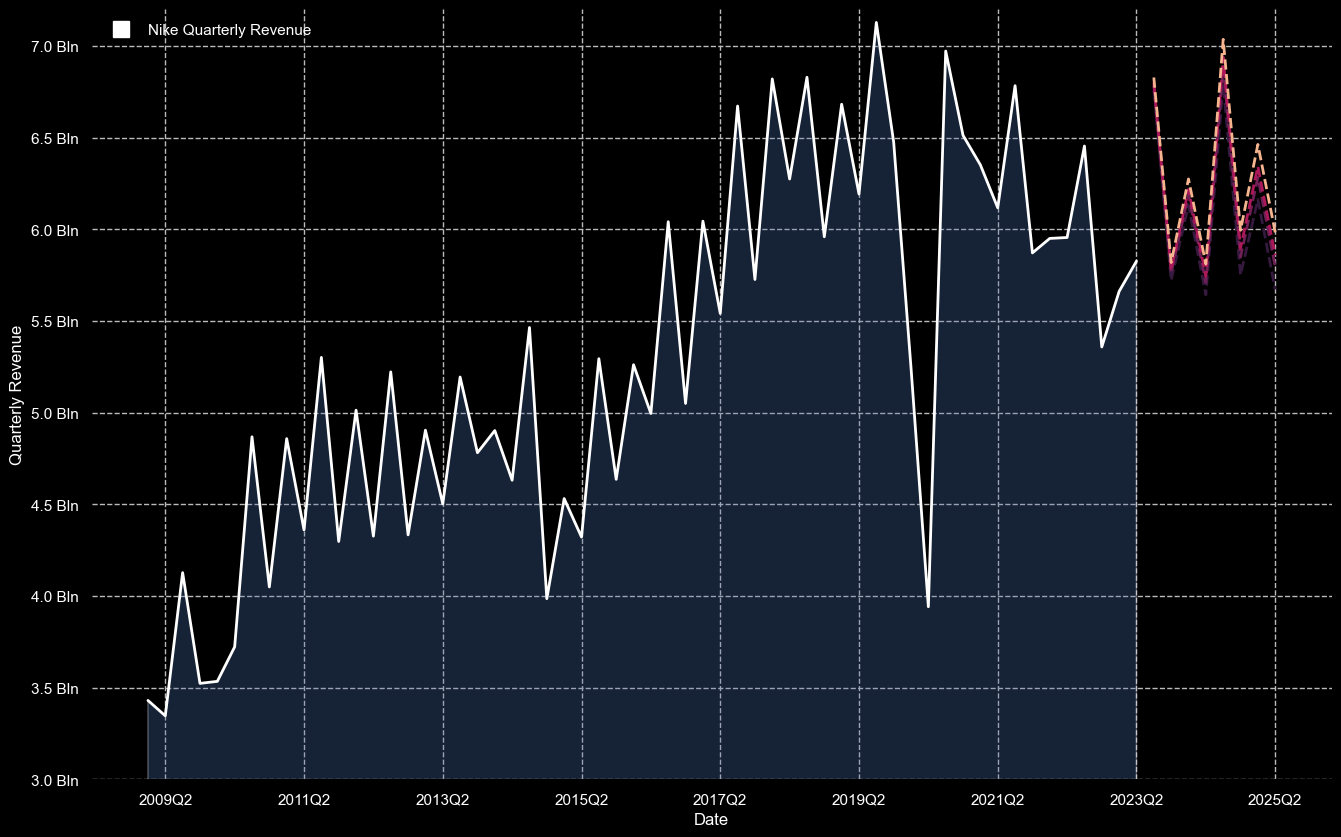

In [105]:
sns.set_theme(color_codes=True)
sns.set(rc={'figure.figsize':(16,10)})
sns.set(rc={'axes.facecolor':'#000', 'figure.facecolor':'#000'})
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(linestyle='--', color="#bdbaba")
ax = sns.lineplot(data=combined_df, x="Date", y="Quarterly Revenue", linewidth = 2, color="white")
ax2 = sns.lineplot(data=combined_df, x="Date", y="theta=1.2", linewidth = 2, color="#35193e", linestyle="dashed")
ax2 = sns.lineplot(data=combined_df, x="Date", y="theta=2", linewidth = 2, color="#701f57", linestyle="dashed")
ax2 = sns.lineplot(data=combined_df, x="Date", y="theta=3", linewidth = 2, color="#ad1859", linestyle="dashed")
ax2 = sns.lineplot(data=combined_df, x="Date", y="No damping", linewidth = 2, color="#f6b48f", linestyle="dashed")
ax.set(ylabel='Quarterly Revenue', xlabel="Date")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_xticks(range(1, 72,8))
plt.xticks(rotation=0)
plt.fill_between(combined_df['Date'], combined_df['Quarterly Revenue'], alpha=0.3)
# Define custom legend handler with a square marker
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Nike Quarterly Revenue', 
                          linestyle='None', markerfacecolor='white', markersize=12)]
ax.legend(handles=legend_elements, labelcolor='white', loc='upper left', bbox_to_anchor=(0, 1), frameon=False)
ax.set_ylim(3e9, 7.2e9)
sns.despine(left=True, bottom=True)
# Set the y-axis formatter
ax = plt.gca()
formatter = CustomFormatter()
ax.yaxis.set_major_formatter(formatter)